Generate a fascicle with all contexts
=====================================


This example shows how to easily generate and save a fascicle with the
following contexts:

-  **Intracellular context**: A current attached to all axons at $x=0$.
-  **Recording context** : An analytical recorder is added with three recording points located at $x\in\{\frac{L}{4}, \frac{L}{2}, \frac{3L}{4}\}$, $y=0$, $z=100$.
-  **Extracellular context**: A LIFE electrode is added to the centre of the fascicle $x=\frac{L}{2}$, $y=0$, $z=0$.

This example can be used as a model to generate all sorts of fascicles
with a customised context. For instance, it is used to generate the
simulation context for many other examples in this documentation.

In [1]:
import sys
sys.path.append("../../../")
import nrv

import matplotlib.pyplot as plt
import os


Fascicle declaration
--------------------

The first step before generating a fascicle is to create a population of
axons using the ``create_axon_population`` function.

Then the fascicle can be generated and filled with the population.

*Note that the population can be saved in a* ``.pop`` *or a* ``.ppop`` *file. This allows
different fascicles to be generated with the same proportions of axons
but with different locations.*

In [2]:
n_ax = 60

axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_ax, percent_unmyel=0.7, M_stat="Ochoa_M", U_stat="Ochoa_U",)

NRV INFO: On 60 axons to generate, there are 18 Myelinated and 42 Unmyelinated


In [3]:
L = 10000 			# length, in um

fascicle_1 = nrv.fascicle(ID=1)
fascicle_1.define_length(L)
fascicle_1.fill_with_population(axons_diameters, axons_type, delta=5)
fascicle_1.fit_circular_contour(delta = 0.1)
fascicle_1.generate_random_NoR_position()

NRV INFO: Axon packing initiated. This might take a while...


NRV INFO: Packing done!
NRV WARNING: fit_circular_contour method usage is not recommended anymore and will be removed in future release.
NRV INFO: Define fascicle size/shape at object creation instead.


Once the fascicle geometry is generated all the contexts can be added: 

  **- The intracellular context**

In [6]:
position = 0.
t_start = 1
duration = 0.5
amplitude = 4
fascicle_1.insert_I_Clamp(position, t_start, duration, amplitude)

  **- The recording context**

In [7]:
testrec = nrv.recorder("endoneurium_bhadra")
testrec.set_recording_point(L/4, 0, 100)
testrec.set_recording_point(L/2, 0, 100)
testrec.set_recording_point(3*L/4, 0, 100)
fascicle_1.attach_extracellular_recorder(testrec)

**\- The extracellular context**

*Note that the extracellular can have an impact one the final axon population. For instance all axons overlapping with a LIFE electrode are automatically removed.*

In [8]:
LIFE_stim = nrv.FEM_stimulation()
# Simulation box size
Outer_D = 5
LIFE_stim.reshape_outerBox(Outer_D)
# Nerve and fascicle geometry
Fascicle_D = fascicle_1.D
Nerve_D = Fascicle_D * 1.5
LIFE_stim.reshape_nerve(Nerve_D, L)
LIFE_stim.reshape_fascicle(Fascicle_D)
# electrode and stimulus definition
D_1 = 25
length_1 = 1000
y_c_1 = 0
z_c_1 = 0
x_1_offset = (L-length_1)/2
elec_1 = nrv.LIFE_electrode("LIFE_1", D_1, length_1, x_1_offset, y_c_1, z_c_1)
# stimulus def
start = 1
I_cathod = 40
I_anod = I_cathod/5
T_cathod = 60e-3
T_inter = 40e-3
stim1 = nrv.stimulus()
stim1.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
LIFE_stim.add_electrode(elec_1, stim1)
fascicle_1.attach_extracellular_stimulation(LIFE_stim)

NRV INFO: From Fascicle 1: Electrode/Axons overlap, 12 axons will be removed from the fascicle
NRV INFO: 60 axons remaining


## Save/Load Fascicle

As the ``fascicle``-class inherits from ``NRVClass``, the save and load methods can be used to generate a python dictionary or save the properties of the fascicle (see `usersguide`). 

As for all ``simulable``-class instances, contexts are not saved and loaded by default. One need specifies which context to save and load using boolean arguments ``extracel_context``,``intracel_context``, ``rec_context``.


<div class="alert alert-info">
 - *Because fascicles can take a long time to generate, the `document` class is one of the few classes in NRV for which save saves automatically (without specifying `save=True` in the argument). If note is specified, the document will be saved in the current directory in `fascicle.json`*.
 - *The footprint of the electrodes on the axon can be generated before saving using `compute_electrodes_footprints`. This can increase the file size but also significantly reduce the computation time of the loaded fascicle simulation*.
</div>

.. Warning::
 - *Some fascicle parameters (length, diameter, ...) cannot be modified if footprints are calculated*.

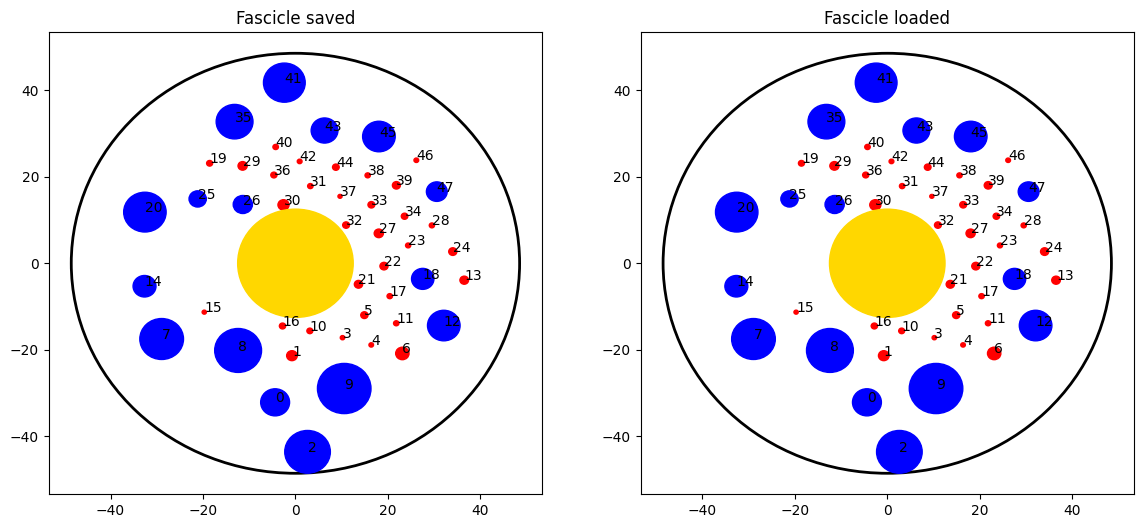

In [9]:
fas_dict = fascicle_1.save(save=False,extracel_context=True,intracel_context=True, rec_context=True)
nrv.synchronize_processes()
#fascicle_2 = nrv.fascicle()
fascicle_2 = nrv.load_any(fas_dict,extracel_context=True,intracel_context=True, rec_context=True)

if nrv.MCH.do_master_only_work():
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    fascicle_1.plot(ax[0], num=True)
    ax[0].set_title("Fascicle saved")
    fascicle_2.plot(ax[1], num=True)
    ax[1].set_title("Fascicle loaded")
